# Variant C/D suggested edits – Regression models

The approach for fitting regression models to predict whether users are likely to make newcomer task edits is the same as we've used in the previous analyses. Because the outcome is binary, either a user edited or they didnt', we use a logistic regression model. We add predictors iteratively until we find the most likely model. Like before, we have predictors for which variant the user had, whether they registered on desktop or mobile, and when they registered (in time since the start of the experiment).

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
## libraries
library(tidyverse)
library(data.table)
library(ggplot2)

library(lme4)

library(caret)

library(interactions)
library(multcomp)
library(emmeans)

require(gridExtra)

## library(ROCR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: mvtnorm

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package

## Configuration variables

In [3]:
## Set BLAS threads to 1 so glmer doesn't use all cores
library(RhpcBLASctl)
blas_set_num_threads(4)

## parallelization
options(mc.cores = 4)

### Helper functions

In [4]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC = function(mod, val_data, col_name, plot_title, cutoff_steps = 0.1) {
  preds = predict(mod, val_data, type = "response")
  ROCR_pred = prediction(preds, val_data[[col_name]])
  ROCR_perf = performance(ROCR_pred, "tpr", "fpr")
  plot(ROCR_perf, colorize = TRUE, print.cutoffs.at = seq(0, 1, by = cutoff_steps),
       text.adj = c(-0.2, 1.7), main = plot_title)
}

## Function to output a confusion matrix
confusion_matrix = function(model_predictions, threshold, reference, levels = c("yes", "no")) {
  pred = factor(ifelse(model_predictions >= threshold, levels[1], levels[2]), levels = levels)
  truth = factor(ifelse(reference, levels[1], levels[2]), levels = levels)
  confusionMatrix(pred, truth, mode = 'prec_recall')
}


### Data import and setup

In [5]:
tagged_edits = fread('datasets/variant-test-2-edit-data.tsv',
                     colClasses = c(wiki_db = 'factor', user_registration = 'character'))

Our dataset contains this many Homepage-enabled registrations in total:

In [6]:
length(tagged_edits[hp_enabled == 1]$wiki)

[1] 53982

Note that the dataset does not include known test accounts, users who were in the control group (meaning they didn't have the Homepage enabled upon registration), or users who turned the Homepage on/off during the experiment.

In [7]:
## Configuration variables for this experiment.
start_ts = as.POSIXct('2020-10-28 18:40:02', tz = 'UTC')
end_ts = as.POSIXct('2020-11-25 18:40:02', tz = 'UTC')

## Convert user_registration into a timestamp
tagged_edits[, user_reg_ts := as.POSIXct(user_registration, format = '%Y%m%d%H%M%S', tz = 'UTC')]

## Calculate time since start of experiment in weeks
tagged_edits[, exp_days := 0]
tagged_edits[, exp_days := difftime(user_reg_ts, start_ts, units = "days")]
tagged_edits[, ln_exp_days := log(1 + as.numeric(exp_days))]
tagged_edits[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(tagged_edits)

## Create boolean column for whether the user edited
tagged_edits[, did_edit := num_suggested_edits > 0]

## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

## Remove all control group users, 
exp_users = tagged_edits[hp_enabled == 1 & hp_variant != '0']

## Split the experiment users into training, testing, and validation datasets
trainIndex <- createDataPartition(exp_users$hp_variant,
                                  p = .8, 
                                  list = FALSE, 
                                  times = 1)
exp_users_train = exp_users[trainIndex,]
exp_users_second = exp_users[-trainIndex,]

testIndex = createDataPartition(exp_users_second$hp_variant, p = .5, list = FALSE, times = 1)

exp_users_test = exp_users_second[testIndex,]
exp_users_validate = exp_users_second[-testIndex,]


## Variant C/D as a predictor

In this first model, we predict whether the user edited based on the variant the user was in, while allowing the overall probability of editing to vary by wiki.

In [12]:
## 1: only variant as a predictor:
edit.model.1 = glmer(formula = did_edit ~ hp_variant + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [13]:
summary(edit.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ hp_variant + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  8791.2   8817.2  -4392.6   8785.2    43159 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1883 -0.1657 -0.1341 -0.1239  9.0445 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.101    0.3178  
Number of obs: 43162, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.87609    0.10054 -38.552   <2e-16 ***
hp_variantD -0.00915    0.06676  -0.137    0.891    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.329

This model suggests that overall, variant is not associated with a difference in probability of making a tagged edit.

Let us see if there's variation by wiki on this.

In [14]:
## 1: only variant as a predictor:
edit.model.1.2 = glmer(formula = did_edit ~ hp_variant + (1 + hp_variant | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [15]:
summary(edit.model.1.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ hp_variant + (1 + hp_variant | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  8795.1   8838.5  -4392.6   8785.1    43157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1888 -0.1657 -0.1349 -0.1241  9.0938 

Random effects:
 Groups  Name        Variance Std.Dev. Corr
 wiki_db (Intercept) 0.099039 0.31471      
         hp_variantD 0.004089 0.06394  0.05
Number of obs: 43162, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.87333    0.10068  -38.47   <2e-16 ***
hp_variantD -0.01570    0.07476   -0.21    0.834    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.333

In [16]:
ranef(edit.model.1.2)

$wiki_db
       (Intercept)   hp_variantD
arwiki -0.35404034 -0.0256666572
cswiki -0.06900831 -0.0050299861
fawiki  0.53934560 -0.0074050489
frwiki -0.29621150  0.0120409184
hewiki  0.21336268 -0.0035156827
huwiki  0.10202484  0.0126160669
hywiki -0.11468610  0.0009386505
kowiki -0.51134061 -0.0148061238
plwiki  0.20413091 -0.0029191728
ptwiki -0.13329579 -0.0176369278
ruwiki  0.32727535  0.0474289115
srwiki  0.03319705  0.0035042439
svwiki -0.05539796 -0.0097914613
trwiki  0.27775492  0.0084623309
ukwiki  0.09066297  0.0131001710
viwiki -0.12368013 -0.0072245448

with conditional variances for “wiki_db” 

The model is not singular, which suggests that there's enough variation and data to support it. However, the BIC is much worse than the first model. So while there *is* some variation between wikis, it's not large enough to mean anything.

## Desktop/mobile registration

We add whether the user registered on desktop or mobile as a predictor.

In [18]:
## 2: add desktop/mobile
edit.model.2 = glmer(formula = did_edit ~ hp_variant + reg_on_mobile + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [19]:
summary(edit.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ hp_variant + reg_on_mobile + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  8777.5   8812.2  -4384.7   8769.5    43158 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2049 -0.1662 -0.1420 -0.1238  9.9548 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.1049   0.3239  
Number of obs: 43162, groups:  wiki_db, 16

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -3.772666   0.104689 -36.037  < 2e-16 ***
hp_variantD   -0.008711   0.066766  -0.130    0.896    
reg_on_mobile -0.282008   0.071636  -3.937 8.26e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_variantD -0.316       
reg_on_mobl -0.230 -0.002

We see that where the user registers also has a strong effect on their likelyhood of making a tagged edit. Here we see the effect is at most 7% (0.28/4) lower if the user is on mobile. There's also a somewhat lower BIC in this model, suggesting that we're getting a slightly better fit.

## Interaction between variant and desktop/mobile

One of the key findings of our previous analysis was that there was a strong interaction effect between which variant group the user was in, and whether they registered on desktop or mobile. An *interaction effect* means that the effect of one of the predictors is altered by the effect of another predictor. In our case, since both predictor are binary categorical variables, it means that the outcome is altered depending on the combination of those categories.

In [20]:
## 3: desktop/mobile interaction
edit.model.3 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

In [21]:
summary(edit.model.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ hp_variant * reg_on_mobile + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  8770.3   8813.7  -4380.2   8760.3    43157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2116 -0.1650 -0.1369 -0.1242 10.6955 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.105    0.3241  
Number of obs: 43162, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -3.85256    0.10919 -35.284  < 2e-16 ***
hp_variantD                0.14616    0.08428   1.734  0.08286 .  
reg_on_mobile             -0.07812    0.09742  -0.802  0.42263    
hp_variantD:reg_on_mobile -0.42042    0.13922  -3.020  0.00253 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       

This model suggests that there might be some interactions between platform and variant, which we've also seen in previous analyses. We'll dig into that a little further down when we've trained a model on the entire dataset.

In [ ]:
plot_ROC(edit.model.3, exp_users_validate, 'did_edit', "Model 3 ROC", cutoff_steps = 0.025)

## Variation across wikis

We test if the effect of these predictors vary significantly by wiki.

In [22]:
## 4: interaction as group-level predictors
edit.model.4 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                      (1 + hp_variant * reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [ ]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(edit.model.4, c("theta", "fixef"))
edit.model.4 = update(edit.model.4, start = start_vals,
                     control = glmerControl(optCtrl = list(maxfun = 2e4)))


In [25]:
## variant and desktop/mobile as group-level predictors, but no interaction
edit.model.4.1 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                      (1 + hp_variant + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [26]:
## just mobile as group-level predictors
edit.model.4.2 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                      (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



In [27]:
## just variant as group-level predictors
edit.model.4.3 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                      (1 + hp_variant | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)

boundary (singular) fit: see ?isSingular



The models converge, but we get a warning that the fit is "singular". From previous analyses, we've learned that this means that the variation between wikis is not large enough to be detectable. In our previous analyses, this was thought to be primarily because we had only four wikis. Now we have 16, but I think it's connected to how much variation is left considering the other predictors. It looks like the variant/platform interaction is our main effect here.

## Time as a predictor

Lastly, we add time as a predictor, in this case a variable measuring the number of weeks between when the user registered and the start of the experiment. This enables us to understand if the probability of a user editing changes as time progresses.

In [23]:
## 5: add time
edit.model.5 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                      ln_exp_weeks + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [24]:
summary(edit.model.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ hp_variant * reg_on_mobile + ln_exp_weeks + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  8771.0   8823.1  -4379.5   8759.0    43156 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2173 -0.1654 -0.1371 -0.1232 10.6562 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.1054   0.3246  
Number of obs: 43162, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -3.94622    0.13670 -28.868  < 2e-16 ***
hp_variantD                0.14709    0.08430   1.745  0.08099 .  
reg_on_mobile             -0.07675    0.09744  -0.788  0.43089    
ln_exp_weeks               0.08946    0.07800   1.147  0.25138    
hp_variantD:reg_on_mobile -0.41997    0.13927  -3.016  0.00257 ** 
---
Signif. codes:  0 ‘

In [28]:
## 5.1: time in days
edit.model.5.1 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                      ln_exp_days + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users_train)


In [29]:
summary(edit.model.5.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ hp_variant * reg_on_mobile + ln_exp_days + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  8771.0   8823.0  -4379.5   8759.0    43156 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2165 -0.1654 -0.1372 -0.1232 10.6371 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.1054   0.3246  
Number of obs: 43162, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -3.98852    0.15970 -24.975  < 2e-16 ***
hp_variantD                0.14701    0.08430   1.744  0.08118 .  
reg_on_mobile             -0.07679    0.09745  -0.788  0.43067    
ln_exp_days                0.05336    0.04550   1.173  0.24090    
hp_variantD:reg_on_mobile -0.41987    0.13927  -3.015  0.00257 ** 
---
Signif. codes:  0 ‘*

It appears that time does not have an effect in this experiment, and adding it does not improve fitness as the BIC is lower. Since the experiment only ran over 4 weeks, and there isn't anything that significantly changes wiki processes (e.g. there's not a need for support systems to ramp up capacity), it makes sense that time isn't a strong factor here. Given the higher BIC and the lack of a significant predictor, I choose to remove it again.

## Model across the entire dataset

Our previous models were trained on a random 80% of our dataset. We switch to the full dataset and model again to get a sense of the predictors across all available data.

In [30]:
## 7: full model
full.edit.model = glmer(formula = did_edit ~ hp_variant * reg_on_mobile + (1 | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

In [31]:
summary(full.edit.model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ hp_variant * reg_on_mobile + (1 | wiki_db)
   Data: exp_users

     AIC      BIC   logLik deviance df.resid 
 11010.9  11055.4  -5500.5  11000.9    53946 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2090 -0.1663 -0.1375 -0.1267 11.0501 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.1056   0.3249  
Number of obs: 53951, groups:  wiki_db, 16

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -3.87060    0.10498 -36.871  < 2e-16 ***
hp_variantD                0.15590    0.07487   2.082  0.03732 *  
reg_on_mobile             -0.13006    0.08821  -1.474  0.14036    
hp_variantD:reg_on_mobile -0.32650    0.12379  -2.637  0.00835 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (

Let's check to see if there's group-level variation when we fit across the entire dataset.

In [64]:
## 7: full model with group-level variation and interaction
full.edit.model.1 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                          (1 + hp_variant * reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

boundary (singular) fit: see ?isSingular



In [65]:
## 7: full model with group-level variation but no interaction
full.edit.model.2 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                          (1 + hp_variant + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

boundary (singular) fit: see ?isSingular



In [66]:
## 7: full model with group-level variation in Homepage variant
full.edit.model.3 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                          (1 + hp_variant | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

boundary (singular) fit: see ?isSingular



In [68]:
## 7: full model with group-level variation in platform
full.edit.model.4 = glmer(formula = did_edit ~ hp_variant * reg_on_mobile +
                          (1 + reg_on_mobile | wiki_db),
                    family = binomial(link = "logit"), data = exp_users)

boundary (singular) fit: see ?isSingular



All of the models with group-level variation are singular, indicating that neither of them is worth pursuing. We discard them and keep the original model without group-level variation in the predictors.

Estimating the effects using the "divide by 4 rule".

In [71]:
100 * fixef(full.edit.model)[2] / 4

hp_variantD 
    3.89755

In [72]:
100 * fixef(full.edit.model)[4] / 4

hp_variantD:reg_on_mobile 
                 -8.16242

In [70]:
100 * (fixef(full.edit.model)[2] + fixef(full.edit.model)[4]) / 4

hp_variantD 
   -4.26487

The model across the full dataset shows the same trends as we saw with this model on the smaller dataset. In summary:

1. We find no indication of meaningful variation between wikis when it comes to the effects of individual predictors, instead the effects are global. This means that per-wiki variation lies in the overall likelihood of editing.
2. There is no significant difference between desktop and mobile for Variant C.
3. Variant D on desktop is associated with a higher likelihood of making a tagged edit (3.9% increase), while on mobile it's associated with a lower likelihood of making a tagged edit (-8.2% decrease)

## Overview table

Since we've found that results vary by wiki, where the user registered, and what variant they saw, we create an overview table to show how the probability changes.

In [ ]:
reg_counts = exp_users[, list(n_registrations = sum(.N)),
                       by = c('wiki_db', 'reg_on_mobile', 'hp_variant')]
edit_counts = exp_users[did_edit == 1, list(n_edited = sum(.N)),
                        by = c('wiki_db', 'reg_on_mobile', 'hp_variant')]
merged_counts = merge(reg_counts, edit_counts, by = c('wiki_db', 'reg_on_mobile', 'hp_variant'))
merged_counts[, percent_edited := 100 * n_edited / n_registrations]
merged_counts

We'd like to compare the results of this experiment with the Variant A/B experiment. The way the analysis is done is the same, so the numbers can be compared with each other.

In [10]:
merged_counts[wiki_db %in% c('arwiki', 'cswiki', 'kowiki', 'viwiki')]

wiki_db,reg_on_mobile,hp_variant,n_registrations,n_edited,percent_edited
<fct>,<int>,<chr>,<int>,<int>,<dbl>
arwiki,0,C,1093,18,1.6468435
arwiki,0,D,1008,14,1.3888889
arwiki,1,C,2045,28,1.3691932
arwiki,1,D,1992,26,1.3052209
cswiki,0,C,435,12,2.7586207
cswiki,0,D,465,10,2.1505376
cswiki,1,C,135,4,2.9629630
cswiki,1,D,136,1,0.7352941
kowiki,0,C,379,1,0.2638522


In [41]:
merged_counts[, platform := 'desktop']
merged_counts[reg_on_mobile == 1, platform := 'mobile']
merged_counts$platform = factor(merged_counts$platform)

merged_counts$hp_variant = factor(merged_counts$hp_variant)

In [61]:
plots = lapply(unique(merged_counts$wiki_db), function(w) {
    ggplot(merged_counts[wiki_db == w], aes(x = platform, y = percent_edited, fill = hp_variant)) +
        theme_bw() +
        theme(axis.title.x = element_text(size = rel(1.5)),
            axis.text.x = element_text(size = rel(1.25)),
            axis.title.y = element_text(size = rel(1.5)),
            axis.text.y = element_text(size = rel(1.25))) +
        scale_fill_brewer("Variant", palette = 'Set1') +
        labs(x = "Platform", y = "Probability (in %)", title = w) +
        geom_col(position = "dodge2")
})

# ggsave(plot = g, file = "graphs/tagged_edit_probabilities.png",
#       width = 14, height = 7, units = "in", dpi = "retina")

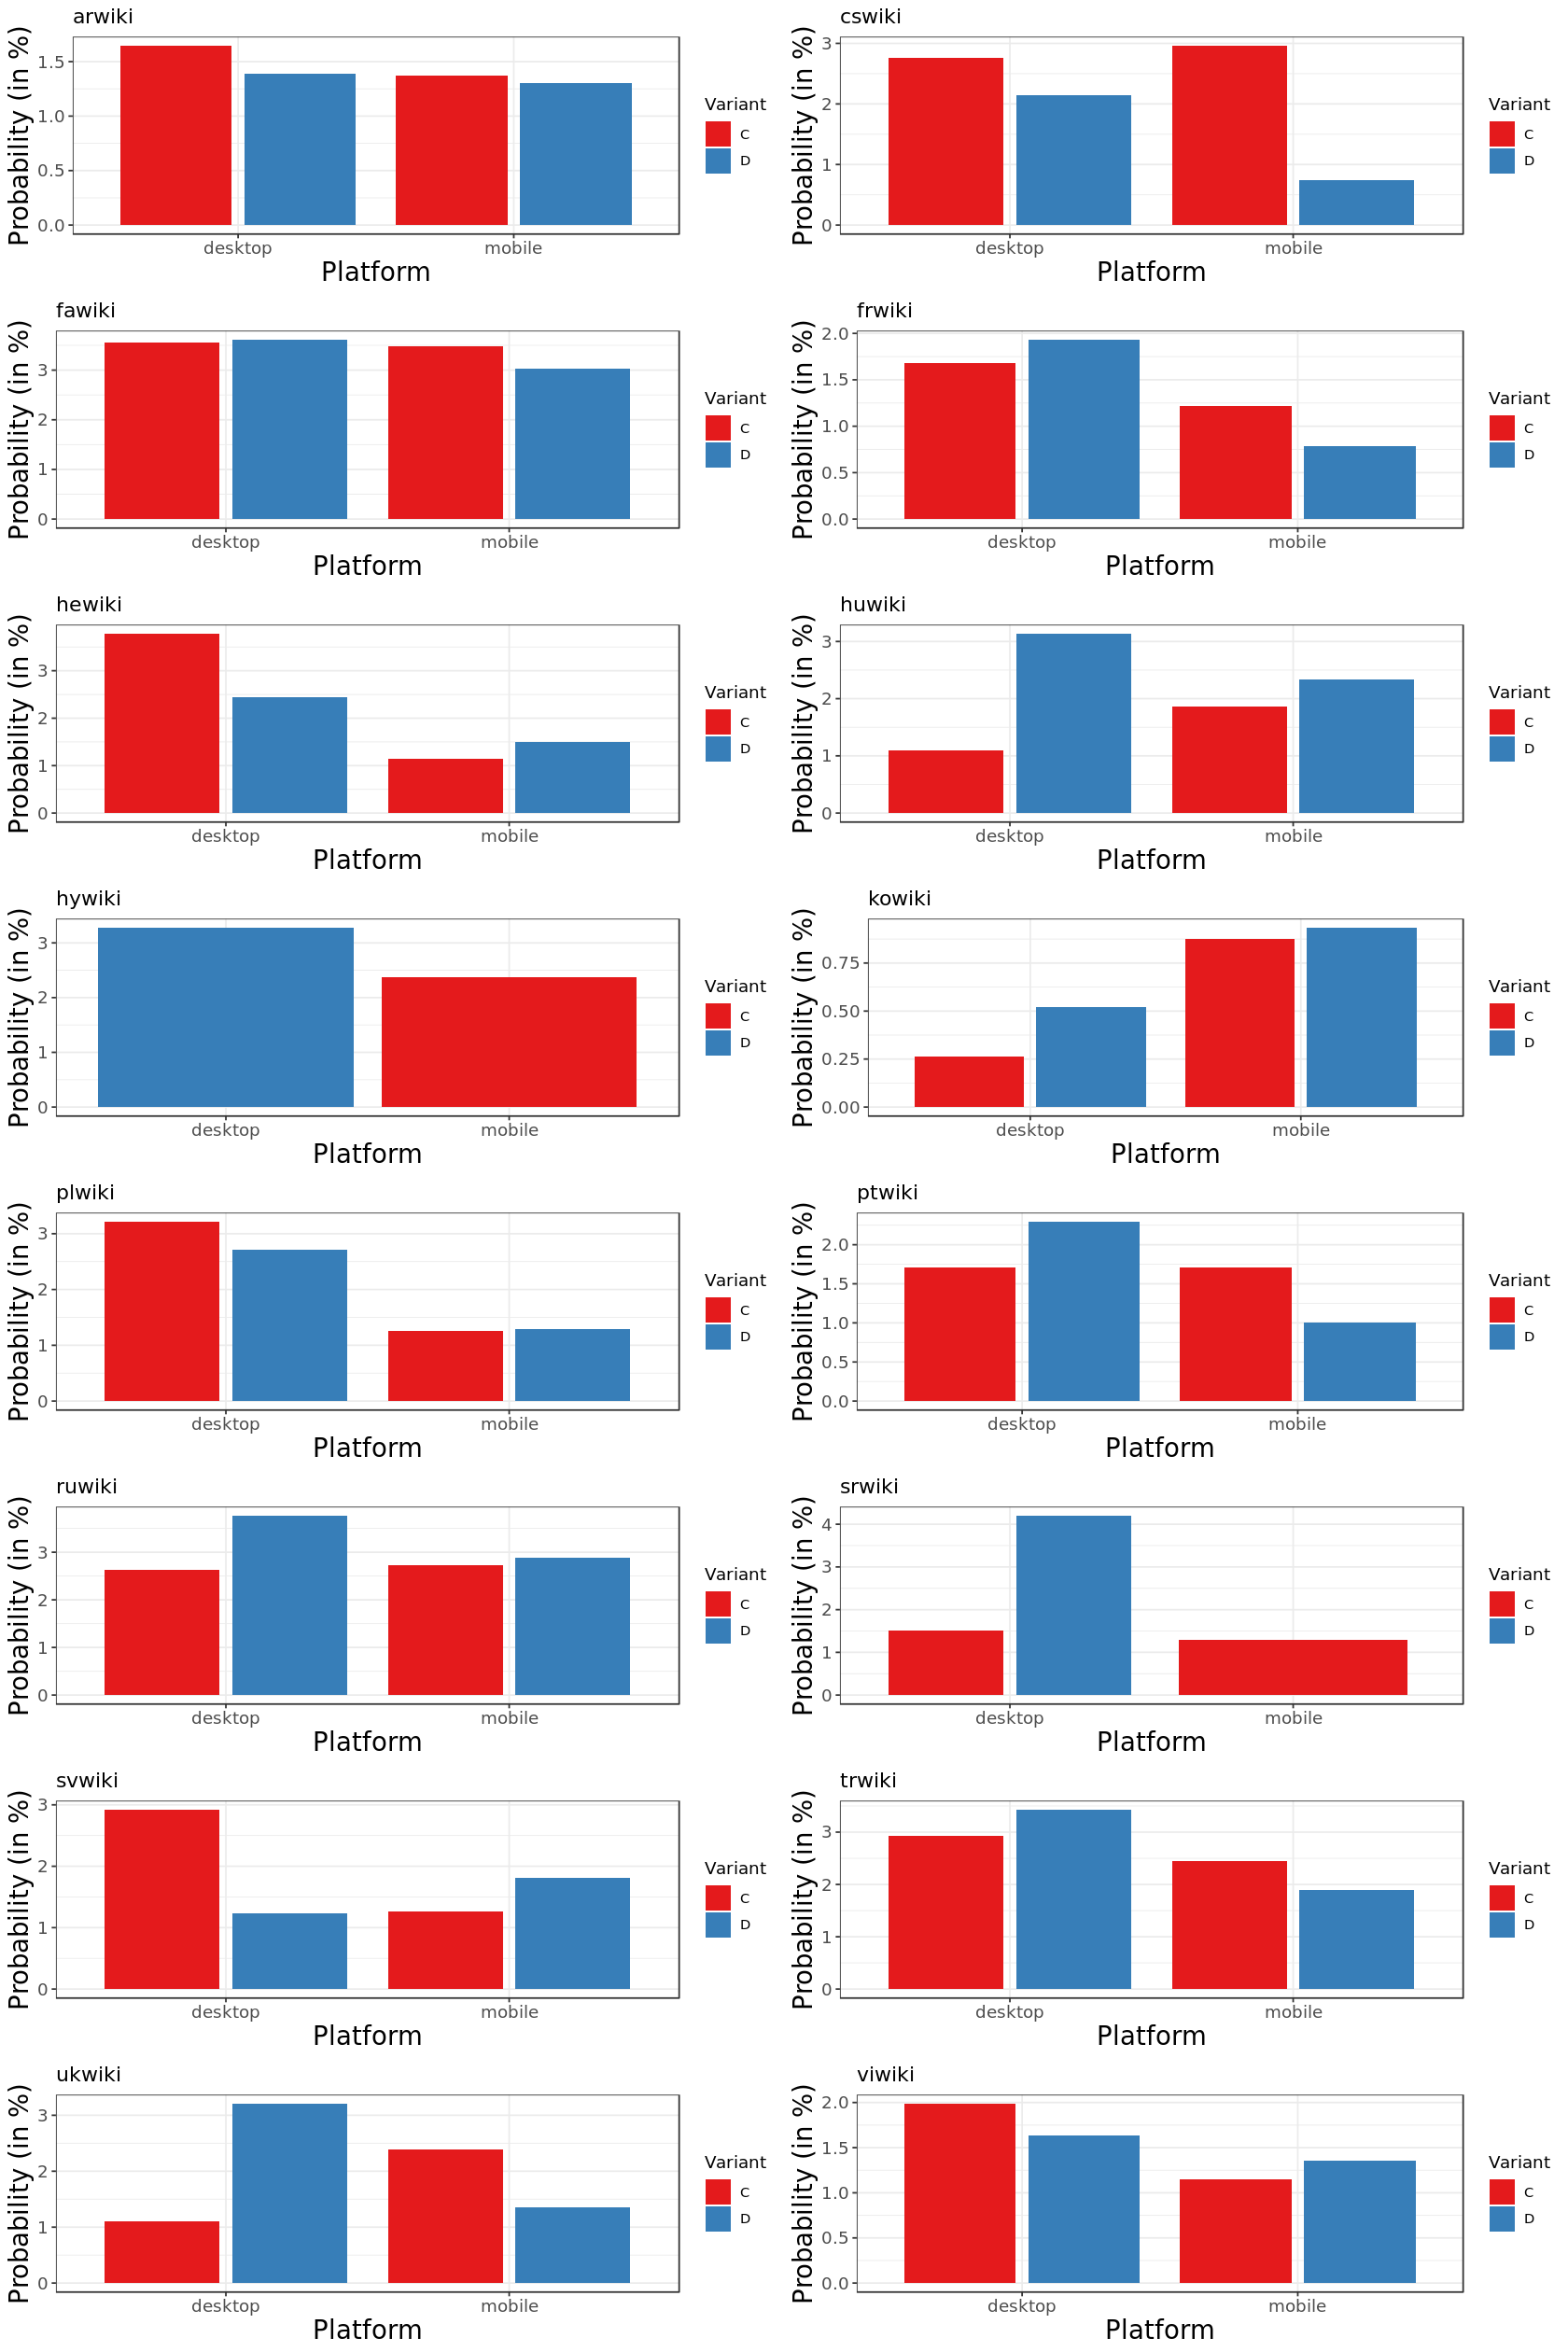

In [62]:
options(repr.plot.width = 14, repr.plot.height = 21)
grid.arrange(grobs = plots, ncol = 2)

## Summary


## Additional analysis

What's the probability difference across the dataset for C vs D? Our model doesn't pick up meaningful per-wiki variation of either platform or variant, so let's just grab the global proportions.

In [73]:
merged_counts[, list(n_registrations = sum(n_registrations), n_edited = sum(n_edited),
                     perc_edited = 100 * sum(n_edited) / sum(n_registrations)),
              by = c('platform', 'hp_variant')]

platform,hp_variant,n_registrations,n_edited,perc_edited
<fct>,<fct>,<int>,<int>,<dbl>
desktop,C,15598,338,2.166944
desktop,D,15519,393,2.532380
mobile,C,11378,227,1.995078
mobile,D,11273,192,1.703185


In [ ]:
(1.409 - 0.820) / 1.409